In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [ ]:
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.tensorflow.data import _parse_function

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

In [5]:
print(tf.__version__, tfp.__version__)

2.1.0 0.9.0


In [6]:
TRAIN_SIZE=101726
BATCH_SIZE=256
TEST_SIZE=10000
DIMS = (128, 128, 1)
N_TRAIN_BATCHES =int((TRAIN_SIZE-TEST_SIZE)/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_SIZE/BATCH_SIZE)
TRAIN_BUF = 1000
TEST_BUF = 1000

In [7]:
network_type = 'GAN'

In [8]:
DATASET_ID = 'starling'

In [9]:
record_loc = DATA_DIR / 'tfrecords' / "starling.tfrecords"

In [10]:
# read the dataset
raw_dataset = tf.data.TFRecordDataset([record_loc.as_posix()])

In [11]:
data_types = {
    "spectrogram": tf.uint8,
    "index": tf.int64,
    "indv": tf.string,
}

In [12]:
# parse each data type to the raw dataset
dataset = raw_dataset.map(lambda x: _parse_function(x, data_types=data_types))

In [13]:
spec, index, indv  = next(iter(dataset))

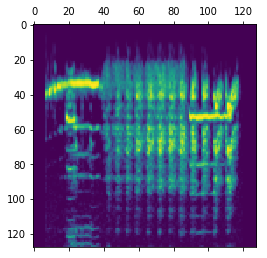

In [14]:
plt.matshow(spec.numpy().reshape(DIMS).squeeze())

In [15]:
test_dataset = dataset.take(TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)
train_dataset = dataset.skip(TEST_SIZE).take(TRAIN_SIZE-TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [16]:
N_Z = 1024

generator = [
    tf.keras.layers.Dense(units=4 * 4 * 256, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(4, 4, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="tanh"
    ),
]

discriminator =  [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [17]:
from avgn.tensorflow.GAN import GAN, plot_reconstruction

In [18]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(1e-4)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

In [19]:
samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))

In [20]:
np.shape(samples)

TensorShape([256, 128, 128, 1])

In [21]:
# exampled data for plotting results
example_data = next(iter(test_dataset))
example_data = (
        tf.cast(tf.reshape(example_data[0], [BATCH_SIZE] + list(DIMS)), tf.float32)
        / 255
)

In [22]:
save_loc = DATA_DIR / 'models' / network_type / DATASET_ID
ensure_dir(save_loc)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
#model.save_weights((save_loc / (str(epoch).zfill(4))).as_posix()) 

# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

In [23]:
model.load_weights((DATA_DIR / 'models/GAN/starling/0341').as_posix()) 

ValueError: Shapes (1024, 4096) and (128, 4096) are incompatible

### J Diagram

In [26]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir
ensure_dir(FIGURE_DIR / 'networks' / 'starling128')

In [27]:
gen_func =  model.generate
interp_len = 5

In [28]:
dset_iter = iter(dataset)
x1 = np.reshape(next(dset_iter)[0] / 255, (1,DIMS[0],DIMS[1],1))
x2 = np.reshape(next(dset_iter)[0] / 255, (1,DIMS[0],DIMS[1],1))
x3 = np.reshape(next(dset_iter)[0] / 255, (1,DIMS[0],DIMS[1],1))
exdat = np.vstack([x1, x2, x3])

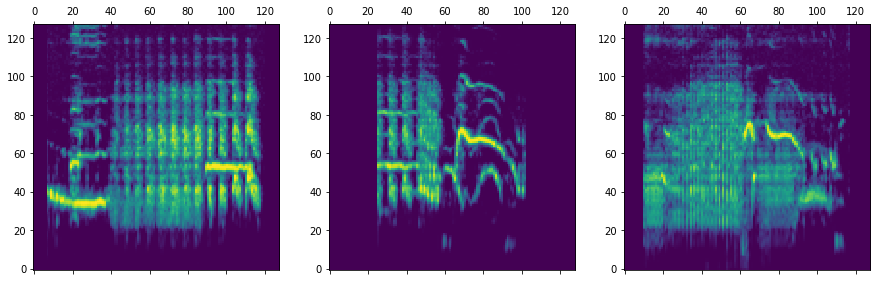

In [29]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].matshow(np.squeeze(x1), origin='lower')
axs[1].matshow(np.squeeze(x2), origin='lower')
axs[2].matshow(np.squeeze(x3), origin='lower')

In [30]:
# make a whole bunch of reconstructions
# get z
all_z = []
all_x = []
for i in tqdm(range(100)):
    z_list = tf.random.normal(shape=(BATCH_SIZE, N_Z))
    x_list = gen_func(z_list).numpy()
    x_list = np.reshape(x_list, (len(x_list), np.product(DIMS)))
    all_x.append(x_list)
    all_z.append(z_list)
all_x = np.vstack(all_x)
all_z = np.vstack(all_z)
np.shape(all_x), np.shape(all_z)

((25600, 16384), (25600, 1024))

In [31]:
x1_dist = np.mean(np.abs(x1.flatten() - all_x), axis = 1)
x2_dist = np.mean(np.abs(x2.flatten() - all_x), axis = 1)
x3_dist = np.mean(np.abs(x3.flatten() - all_x), axis = 1)

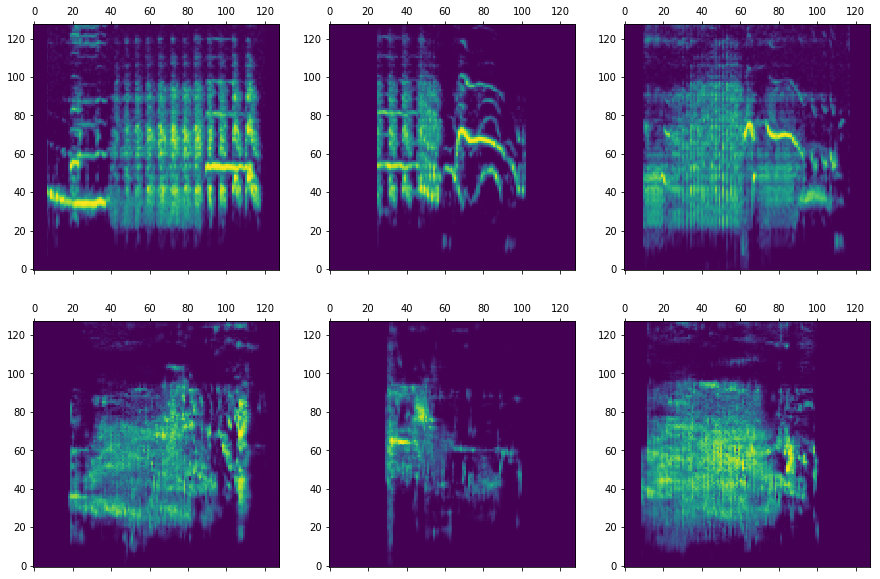

In [32]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
axs[0,0].matshow(np.squeeze(x1), origin='lower')
axs[0,1].matshow(np.squeeze(x2), origin='lower')
axs[0,2].matshow(np.squeeze(x3), origin='lower')
axs[1,0].matshow(all_x[np.argmin(x1_dist)].reshape((DIMS[0],DIMS[1])), vmin=0, origin='lower')
axs[1,1].matshow(all_x[np.argmin(x2_dist)].reshape((DIMS[0],DIMS[1])), vmin=0, origin='lower')
axs[1,2].matshow(all_x[np.argmin(x3_dist)].reshape((DIMS[0],DIMS[1])), vmin=0, origin='lower')

In [33]:
pt1 = all_z[np.argmin(x1_dist)]
pt2 = all_z[np.argmin(x2_dist)]
pt3 = all_z[np.argmin(x3_dist)]

In [34]:
#pt1x,pt2x,pt3x =gen_func(tf.stack([pt1,pt2,pt3]))

#get proportions
z_list = []
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        A = 1 - C - B
        z_list.append(
            C * pt1 +
            B * pt2 + 
            A * pt3
        )
z_list = np.vstack(z_list)
# get X
x_list = gen_func(z_list).numpy()

# make diagram
Jdiagram = np.ones((x_list.shape[1]*(interp_len), x_list.shape[2]*(interp_len+2), x_list.shape[3]))
np.shape(Jdiagram)

#populate
i = 0
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        Jdiagram[(interp_len -1 - bi)*x_list.shape[1]:((interp_len - bi))*x_list.shape[1], (ci+1)*x_list.shape[2]:(ci+2)*x_list.shape[2], :] = x_list[i]
        i+=1
Jdiagram[(interp_len - 1)*x_list.shape[1]: (interp_len)*x_list.shape[1], 
        :x_list.shape[2], :] = x3

Jdiagram[(interp_len - 1)*x_list.shape[1]: (interp_len)*x_list.shape[1], 
        (interp_len +1)*x_list.shape[2]: (interp_len+2)*x_list.shape[2] , :] = x1

Jdiagram[: x_list.shape[1], 
        :x_list.shape[2], :] = x2

(-0.5, 895.5, -0.5, 639.5)

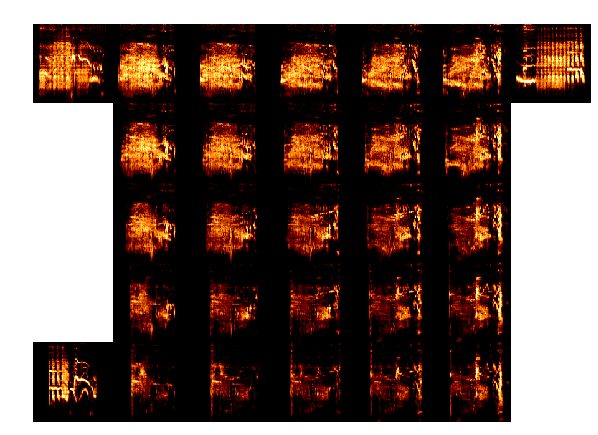

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.squeeze(Jdiagram), vmin = 0, cmap=plt.cm.afmhot, origin = 'lower')
ax.axis('off')
#save_fig(FIGURE_DIR / 'networks' / 'starling128'/ ('GAN_JDiagram3_128'), dpi=300, save_jpg=True)

### plot 3 way interpolation

In [ ]:
gen_func =  model.generate
interp_len = 5

In [ ]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [ ]:
# get z
pt1,pt2,pt3 = tf.random.normal(shape=(BATCH_SIZE, N_Z))[:3]

In [ ]:
#pt1x,pt2x,pt3x =gen_func(tf.stack([pt1,pt2,pt3]))

#get proportions
z_list = []
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        A = 1 - C - B
        z_list.append(
            C * pt1 +
            B * pt2 + 
            A * pt3
        )
z_list = np.vstack(z_list)
# get X
x_list = gen_func(z_list).numpy()

# make diagram
Jdiagram = np.zeros((x.shape[1]*interp_len, x.shape[2]*interp_len, x.shape[3]))
np.shape(Jdiagram)

#populate
i = 0
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        Jdiagram[bi*x.shape[1]:(bi+1)*x.shape[1], ci*x.shape[2]:(ci+1)*x.shape[2], :] = x_list[i]
        i+=1

In [ ]:
ensure_dir(FIGURE_DIR / 'networks' / 'starling128')

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.squeeze(Jdiagram), vmin = 0, cmap=plt.cm.afmhot, origin = 'lower')
ax.axis('off')
save_fig(FIGURE_DIR / 'networks' / 'starling128'/ ('GAN_JDiagram_128'), dpi=300, save_jpg=True)

In [ ]:
### reconstruct back into x